In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import os
import csv
import datetime as d
from datetime import datetime as D
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random 
import time
import math
import scipy
from scipy import stats
from scipy.stats import norm
import scipy.stats as st
import seaborn as sns

### Intialization & data ingestion

In [2]:
M_t=41*7+5
filenum=42
cluster_num=5
data_path='/Users//Desktop/your_path/'
#M_norm is the processed mobility matrix, and density and dwell are the degree of congestion and dwell time, respectively, for the five categories of places in the 42 uhf
M_norm = np.loadtxt(data_path+'M.txt', delimiter = ',').reshape((M_t,42,42*cluster_num))
density=np.loadtxt(data_path+'density.txt', delimiter = ',').reshape((filenum,42*cluster_num))
dwell=np.loadtxt(data_path+'dwell.txt', delimiter = ',').reshape((filenum,42*cluster_num))

# Table of weeks corresponding to dates
f = open(data_path+'dict_day2week.txt','r')
a = f.read()
day2week= eval(a)
f.close()

# New York City Population by UHF
N_raw=pd.read_excel(data_path+'NYCpop.xlsx',usecols=['num'],dtype='int')
N_all=N_raw.values
uhf_name=pd.read_excel(data_path+'uhf_info.xlsx',usecols=['UHF_name'],dtype='str')

# Artificially simulated daily detection rate
sim_raw=pd.read_excel(data_path+"sim_obs.xlsx",dtype='float')
sim_daily_rate=sim_raw.values

# Parameter settings
Z=3.59
D=3.56
a=0.5
b=0.5

sam_num=500 #MH 
para_num=cluster_num+1

#delay model
aver_delay=14
x = np.arange(0.0, 21, 1) 
y1 = st.gamma.pdf(x, 1.85, scale=aver_delay/1.85)
raw=np.array([y1[i+1] for i in range(20)])
prob_gamma=(raw/np.sum(raw)).reshape(20,1)

seed_0=1200#Initial assumption of total NYC infections
s_factor=np.array([0.0077804 , 0.02339975, 0.03096405,0.03509373, 0.020644  ,
       0.0248404 , 0.01729817, 0.02062146, 0.02336571, 0.03521075,
       0.01557102, 0.00760455, 0.06664087, 0.03892939, 0.0254785 ,
       0.01601171, 0.03034952, 0.02062874, 0.02491628, 0.02035715,
       0.01355837, 0.02436521, 0.02877314, 0.02579249, 0.01574011,
       0.01093734, 0.02100978, 0.00591962, 0.02110973, 0.08461017,
       0.01597016, 0.00724917, 0.03076374, 0.01372457, 0.03013459,
       0.03678055, 0.02433973, 0.02106431, 0.00654353, 0.01393221,
       0.01296151, 0.02901384])
seed=seed_0*s_factor#Initial assumption of infections for UHF

#Climate weights
humudity_raw=pd.read_csv(data_path+'NY_humudity.csv')
humudity=humudity_raw[56:56+M_t].values
R_max=2.7
R_min=1.2
hum=(np.exp(-180*humudity+np.log(R_max-R_min))+R_min)/D
hum_factor=hum/np.mean(hum)


In [6]:
def SEIR(currState,currM,infFor,Z,D,betaBase,season_factor):#SEIR
    newState=np.zeros((4,42))
    newcase=np.zeros(42)
    flag=0
    delta_S=currState[0]*((currM.dot(season_factor*infFor)).T)+season_factor*betaBase*currState[0]*currState[2]/(N_all.T)
    test=currState[0]-delta_S
    newState[0] = test
    newState[1] = currState[1]+delta_S-currState[1]/Z
    newState[2] =currState[2]+currState[1]/Z-currState[2]/D
    newcase=currState[1]/Z
    newState[3] = currState[3]+currState[2]/D
    if np.min(newState)<0:      
        flag=1             
    return newState,newcase,flag

def GetLambda(I,N,v_set,a,b,currdensity,currdwell):#Calculate the force of infection at different sites at the current week
    mylambda=np.zeros((42*cluster_num))
    repeat_v=np.tile(v_set,(1,42))
    partial=I/N
    mylambda=repeat_v*partial*(currdensity**a)*(currdwell**b)
    return mylambda.T

def getStart(seed,factor):#Initialize each UHF state variable
    StateStart=np.zeros((4,42))
    for i in range(42):
        s=seed[i]
        StateStart[2][i]=random.uniform(max(s-5,1),s+5)
        StateStart[1][i]=factor*StateStart[2][i]
        StateStart[3][i]=0
        StateStart[0][i]=N_all[i]-StateStart[1][i]-StateStart[2][i]-StateStart[3][i]
    return  StateStart 

def segmented_simulation(para,t1,t2,wnum,uhf_start,statestart,startcase):
    State=np.zeros((t2-t1+1,4,42))
    State[0]=statestart
    v_set=para[0:5]
    beta=para[5]
    flag=0
    uhf_daily_obs=np.zeros(((t2-t1,42)))
    uhf_week_obs=np.zeros(((wnum,42)))
    new_case=startcase.copy()
    for t in range(1,t2-t1+1):
        real_t=t1+t
        deltacase=np.zeros(42)
        I_set=State[t-1][2].dot(M_norm[real_t-1])
        N_set=(N_all.T).dot(M_norm[real_t-1])
        infFor=GetLambda(I_set,N_set,v_set,a,b,density[day2week[real_t-1]],dwell[day2week[real_t-1]])
        State[t],deltacase,flag=SEIR(State[t-1],M_norm[real_t-1],infFor,Z,D,beta,hum_factor[real_t-1])
        if flag==0:
            deltacase=deltacase.reshape(1,42)
            prob_case=prob_gamma.dot(deltacase)
            new_case[real_t:min(real_t+20,t2)]+=prob_case[:min(t2-real_t,20)]
    uhf_daily_obs=sim_daily_rate[t1:t2]*new_case[t1:t2]
    sum_daily_obs=np.sum(uhf_daily_obs,axis=1)
    uhf_week_obs=np.sum(uhf_daily_obs[uhf_start:uhf_start+7*wnum].reshape((wnum,7,42)),axis=1)
    return flag,uhf_week_obs,sum_daily_obs,State[-1],new_case

### Synthetic infection

In [9]:
para0=np.array([31,7 ,30 ,24 ,27 , 0.01])
t1=0
t2=102
state0=getStart(seed,5)
case0=np.zeros((t2,42)) 
uhf_obs,NYC_obs,_,_=segmented_simulation(para0,t1,t2,14,4,state0,case0)[1:]

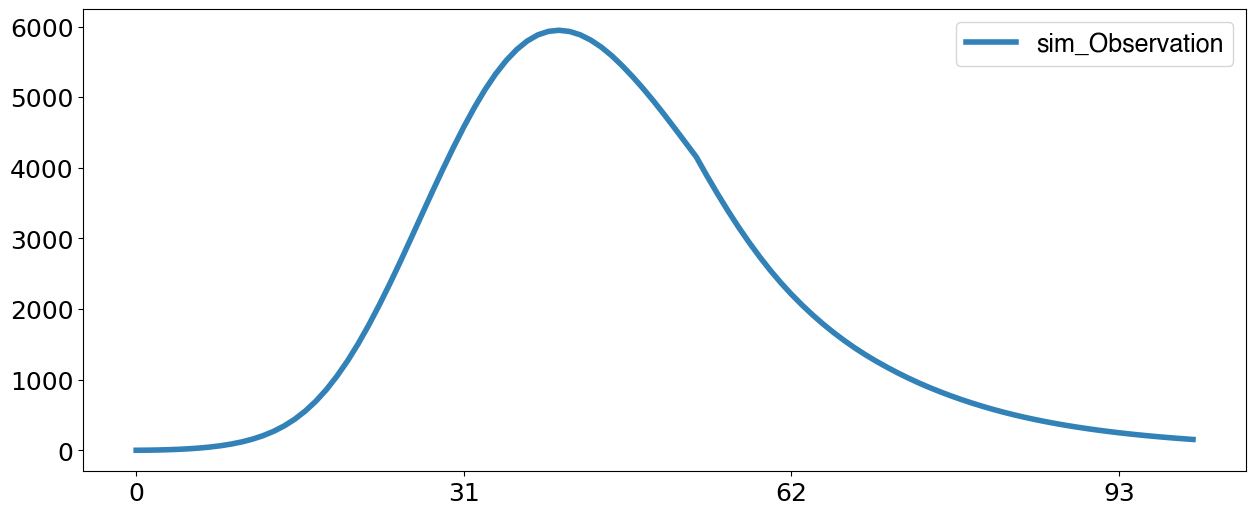

In [10]:
#Plotting infection curves
hex_colors=['#D31616','#3282B8','#F6C90E','#137C00','#8c96c6']
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(NYC_obs[1:],color=hex_colors[1], linewidth=4)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(31))
plt.setp(plt.gca().get_xticklabels(),rotation=0)
text_font = {'family': 'Helvetica', 'size': 18}
plt.legend(labels=['sim_Observation'],prop=text_font )#'case-by-day'
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

#### data save

In [11]:
with open('/###/uhf_sim_obs.txt', 'w') as outfile:
    for i in uhf_obs:
        np.savetxt(outfile, i, delimiter = ',')
np.savetxt('/Users/###/Desktop//NYC_sim_obs.txt', NYC_obs)